In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from common.filter_banks import make_gauss_kernels, make_dog_kernels, show_filter_bank
from common.image_ops import resize_img, whiten_img
from imageio import imread
from skimage.color import rgb2gray
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import img_as_uint
import cv2
from pathlib import Path
import reprlib, os, logging, sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
logging.info('Start')

2020-09-28 08:36:07,575 | INFO : Start


4 4


<IPython.core.display.Javascript object>


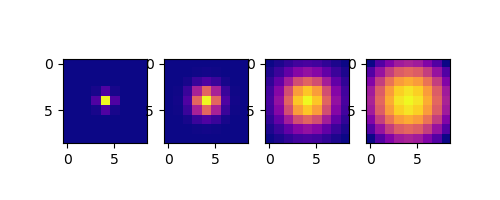

In [3]:
%matplotlib notebook
gauss_kernels_tf = make_gauss_kernels()
show_filter_bank(gauss_kernels_tf)

4 4


<IPython.core.display.Javascript object>


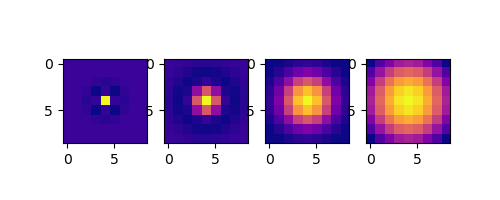

In [4]:
%matplotlib notebook
dog_kernels_tf = make_dog_kernels()
show_filter_bank(dog_kernels_tf)

In [5]:
racoon_path = (Path(os.environ['DATA_ALL']) / 'Misc' / 'racoon').with_suffix('.png')
racoon = imread(racoon_path)
racoon = rgb2gray(racoon)
racoon = resize_img(racoon, sz=128)
racoon = whiten_img(racoon)
racoon = np.reshape(racoon, (1,128,128,1))

<IPython.core.display.Javascript object>


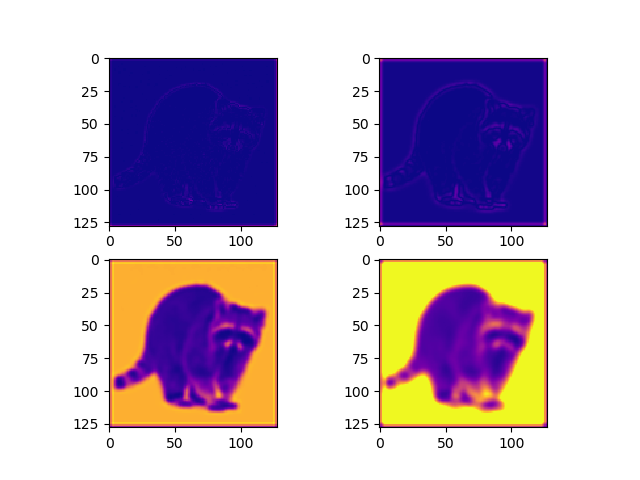

2020-09-28 08:37:06,539 | INFO : 0: 7.636817393741335e-12 > 0.11010541021823883
2020-09-28 08:37:06,542 | INFO : (array([15793,    76,     6,     1,   496,     0,     8,     0,     0,
           4], dtype=int64), array([7.6368174e-12, 1.1010541e-02, 2.2021081e-02, 3.3031624e-02,
       4.4042163e-02, 5.5052705e-02, 6.6063248e-02, 7.7073790e-02,
       8.8084325e-02, 9.9094868e-02, 1.1010541e-01], dtype=float32))
2020-09-28 08:37:06,545 | INFO : 1: 1.343461881455829e-13 > 0.09135635942220688
2020-09-28 08:37:06,547 | INFO : (array([14117,  1577,   124,    47,   490,    17,     0,     8,     0,
           4], dtype=int64), array([1.3434619e-13, 9.1356356e-03, 1.8271271e-02, 2.7406909e-02,
       3.6542542e-02, 4.5678180e-02, 5.4813817e-02, 6.3949451e-02,
       7.3085085e-02, 8.2220726e-02, 9.1356359e-02], dtype=float32))
2020-09-28 08:37:06,549 | INFO : 2: 0.00026602038997225463 > 0.19356846809387207
2020-09-28 08:37:06,551 | INFO : (array([3325, 1622,  780, 1001,  339,  263,  712,  303

In [7]:
%matplotlib notebook
racoon_in_tf = tf.constant(racoon, dtype=tf.float32)
racoon_out = tf.nn.conv2d(racoon_in_tf, dog_kernels_tf,
                          strides=[1, 1, 1, 1],
                          padding='SAME')
racoon_out_sq = racoon_out ** 2

fig, axs = plt.subplots(2,2)
for n in range(4):
    level_img = np.reshape(racoon_out_sq[...,n], (128,128))
    logging.info(f"{n}: {np.min(level_img)} > {np.max(level_img)}")
    logging.info(f"{np.histogram(level_img)}")
    axs[n // 2][n % 2].imshow(level_img, cmap='plasma', vmin=.0, vmax=.2)

3.413847e-05


<IPython.core.display.Javascript object>


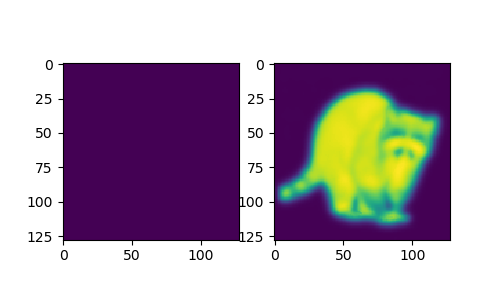

In [19]:
%matplotlib notebook
def mse_tf(current_tf:tf.Tensor, kernel_tf:tf.Tensor, match_tf_sq:tf.Tensor):
    current_out_tf = \
        tf.nn.conv2d(current_tf, kernel_tf,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    current_out_tf_sq = current_out_tf ** 2
    loss_per_level = \
        tf.reduce_mean((current_out_tf_sq - match_tf_sq) ** 2, axis=[0,1,2])
    loss = tf.tensordot(loss_per_level, [16.,8.,2.,1.], 1)
    return loss

sz = 128
current_value = tf.Variable(np.ones((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, dog_kernels_tf, racoon_out_sq)
grad = tape.gradient(current_out, current_value)
print(np.max(grad))
fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

<IPython.core.display.Javascript object>


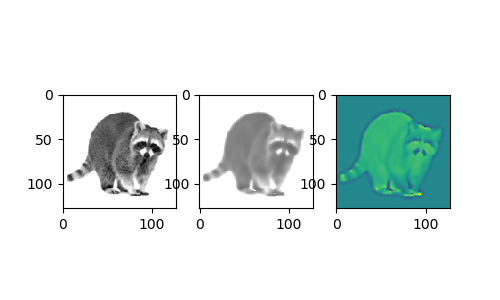

loss = 0.03555015102028847   
loss = 0.031169407069683075   
loss = 0.027530256658792496   
loss = 0.024474985897541046   
loss = 0.021885786205530167   
loss = 0.01967318169772625   
loss = 0.01776818558573723   
loss = 0.01611691527068615   
loss = 0.014676764607429504   
loss = 0.013413690030574799   
loss = 0.012300221249461174   
loss = 0.011313995346426964   
loss = 0.010436654090881348   
loss = 0.009653016924858093   
loss = 0.00895044393837452   
loss = 0.008318338543176651   
loss = 0.007747771218419075   
loss = 0.007231169380247593   
loss = 0.006762079894542694   
loss = 0.0063349781557917595   
loss = 0.005945110693573952   
loss = 0.005588371306657791   
loss = 0.005261198617517948   
loss = 0.004960492253303528   
loss = 0.004683542065322399   
loss = 0.004427971318364143   
loss = 0.004191691521555185   
loss = 0.003972857724875212   
loss = 0.0037698380183428526   
loss = 0.003581184661015868   
loss = 0.0034056089352816343   
loss = 0.0032419615890830755   
loss = 0.

In [20]:
%matplotlib notebook
fig, axs = plt.subplots(1,3,figsize=(5,3))
learning_rate = 1e+3
for n in range(100):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, dog_kernels_tf, racoon_out_sq)
        tf.print(f"loss = {current_out}   ")
    grad = tape.gradient(current_out, current_value)
axs[0].imshow(np.reshape(racoon[...,0], (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[1].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray', vmin=0., vmax=0.8)
axs[2].imshow(tf.reshape(grad, (sz,sz)))
plt.show()

2020-09-28 08:45:40,334 | INFO : (array([3321,   59,   60,   48,   35,  860, 4647, 1229, 5984,  141],
      dtype=int64), array([29744. , 30109.2, 30474.4, 30839.6, 31204.8, 31570. , 31935.2,
       32300.4, 32665.6, 33030.8, 33396. ]))
2020-09-28 08:45:40,348 | INFO : (array([ 538, 3757, 3360,  964,  977, 1617, 1871, 1865,  953,  482],
      dtype=int64), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


<IPython.core.display.Javascript object>


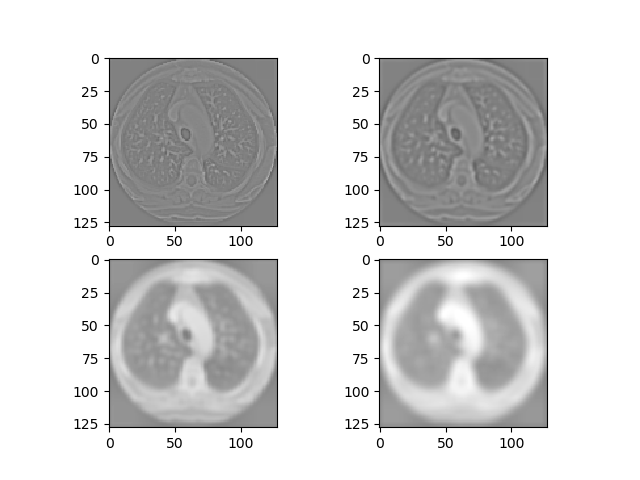

In [21]:
%matplotlib notebook
sz = 128
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
slice_path = Path(os.environ['DATA_ALL']) / 'NIH_DeepLesion' / 'Images_png_01' / 'Images_png' / '000001_01_01' / '108.png'
transverse_slice = imread(slice_path)
transverse_slice = resize(transverse_slice, (sz,sz))
transverse_slice = img_as_uint(transverse_slice)
logging.info(np.histogram(transverse_slice, 10))
transverse_slice = clahe.apply(transverse_slice)
ts_min, ts_max = np.min(transverse_slice), np.max(transverse_slice)
ts_width = ts_max - ts_min
transverse_slice = (transverse_slice - ts_min) / ts_width
transverse_slice = np.reshape(transverse_slice, (1,sz,sz,1))
logging.info(np.histogram(transverse_slice, 10))

transverse_slice_tf = tf.constant(transverse_slice, dtype=tf.float32)
transverse_slice_out_tf = \
    tf.nn.conv2d(transverse_slice_tf, dog_kernels_tf,
                 strides=[1, 1, 1, 1],
                 padding='SAME')
transverse_slice_out_tf_sq = \
    transverse_slice_out_tf ** 2

fig, axs = plt.subplots(2,2)
for n in range(4):
    level_img = np.reshape(transverse_slice_out_tf[...,n], (sz,sz))
    axs[n // 2][n % 2].imshow(level_img, cmap='gray', vmin=-.5, vmax=.5)

<IPython.core.display.Javascript object>


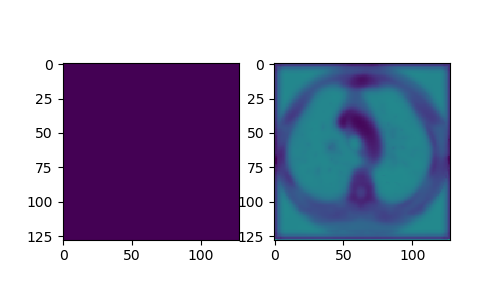

In [23]:
current_value = tf.Variable(np.ones((1,sz,sz,1)), dtype=tf.float32)
with tf.GradientTape() as tape:
    current_out = mse_tf(current_value, dog_kernels_tf, transverse_slice_out_tf_sq)
grad = tape.gradient(current_out, current_value)

fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)))
axs[1].imshow(tf.reshape(grad, (sz,sz)))

<IPython.core.display.Javascript object>


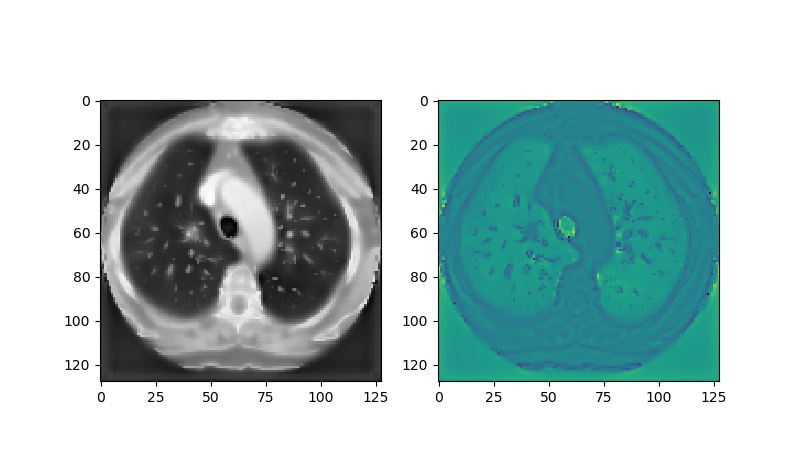

In [27]:
%matplotlib notebook
from IPython.display import clear_output
learning_rate = 1e+3
for n in range(100):
    current_value.assign_sub(learning_rate * grad)
    with tf.GradientTape() as tape:
        current_out = mse_tf(current_value, dog_kernels_tf, transverse_slice_out_tf_sq)
    grad = tape.gradient(current_out, current_value)
    
fig, axs = plt.subplots(1,2,figsize=(5,3))
axs[0].imshow(tf.reshape(current_value, (sz,sz)), cmap='gray')
axs[1].imshow(tf.reshape(grad, (sz,sz)))
plt.show()